<a href="https://colab.research.google.com/github/GymMachineLearning/ml_model_alt/blob/develop/notebooks/preprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Optional cell to install all dependencies

In [36]:
! pip install youtube_transcript_api
! pip install pytubefix
! pip install moviepy
! pip install stumpy

### All imports

In [ ]:
import cv2
from youtube_transcript_api import YouTubeTranscriptApi
from pytubefix import YouTube

import collections
import numpy as np

# nlp toolkit
import nltk

# cv model
import tensorflow as tf
import tensorflow_hub as hub


import imageio
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches


from IPython.display import display, HTML,clear_output
from moviepy.editor import ImageSequenceClip

# enable google colab to use cv2 imshow
from google.colab.patches import cv2_imshow
import csv

### Download specific video from youtube for analysis

In [ ]:

#xwyPjhRoeNc
#nhoikoUEI8U
#ultWZbUMPL8

video_id = "ultWZbUMPL8"
#subtitles = YouTubeTranscriptApi.get_transcript(video_id)
#print(len(subtitles))

yt = YouTube(f"https://www.youtube.com/watch?v={video_id}")

# szorty
#video_id = "iOHAakPpXNQ"
video_id = "gslEzVggur8"
shorts_yt = YouTube(f"https://www.youtube.com/shorts/{video_id}")

stream = shorts_yt.streams.filter(res="720p").first()

#print(yt.streams.filter(res="720p").first())
destination_path = "../videos"
#print(stream)
video_file = stream.download(output_path=destination_path)


# def cv2_to_mediapipe_image(cv2_image):
#     rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
#     image = mp.solutions.mediapipe.python.solution_base.Image(
#         width=rgb_image.shape[1],
#         height=rgb_image.shape[0],
#         rgb_data=np.frombuffer(rgb_image.tobytes(), dtype=np.uint8)
#     )

#     return image

### Movnet in HPE

In [ ]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.

    keypoints_with_scores = outputs['output_0'].numpy()
    #print(keypoints_with_scores)
    return keypoints_with_scores

# Define the edges between keypoints to draw the skeleton
KEYPOINT_EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'y', (2, 4): 'y',
    (0, 5): 'm', (0, 6): 'c', (5, 7): 'm', (7, 9): 'y',
    (6, 8): 'c', (8, 10): 'y', (5, 6): 'c', (5, 11): 'm',
    (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'y',
    (12, 14): 'c', (14, 16): 'y'
}

def draw_keypoints(frame, keypoints, confidence_threshold):
    """Draws the keypoints and the skeleton on the image."""
    y, x, _ = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    # Draw keypoints
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0, 255, 0), -1)

    # Draw skeleton
    for edge, color in KEYPOINT_EDGES.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if c1 > confidence_threshold and c2 > confidence_threshold:
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)


#process_video(video_file)

In [ ]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

angles_to_display = [
        ('left_elbow', 'left_shoulder', 'left_hip'),
        ('right_elbow', 'right_shoulder', 'right_hip'),
        ('left_knee', 'left_hip', 'left_shoulder'),
        ('right_knee', 'right_hip', 'right_shoulder'),
        ('left_ankle', 'left_knee', 'left_hip'),
        ('right_ankle', 'right_knee', 'right_hip'),

]

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape

  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

def calculate_angle(a, b, c):
    """Calculate the angle between three points."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  rectangle = None
  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 1.0)
    ymin = max(crop_region['y_min'] * height, 1.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    rectangle = (int(xmin),int(ymin),int(rec_width),int(rec_height))

   # Calculate angles and display

    #print("czekam")
    #input("Press Enter to continue...")
  scores_values = keypoints_with_scores[:, :, :, 2]


  angles = np.array([])
  joint_coordinates = np.array([])

  avg_score_value = np.mean(scores_values)
  i = 0
  for (joint_a, joint_b, joint_c) in angles_to_display:
      #ax.text(100, 100, f'nowytesttttttttttttt', color='red', fontsize=40, ha='center')
      idx_a = KEYPOINT_DICT[joint_a]
      idx_b = KEYPOINT_DICT[joint_b]
      idx_c = KEYPOINT_DICT[joint_c]

            # if (keypoints_with_scores[0, 0, idx_a, 2] > 0.11 and
            #     keypoints_with_scores[0, 0, idx_b, 2] > 0.11 and
            #     keypoints_with_scores[0, 0, idx_c, 2] > 0.11):
      a = keypoints_with_scores[0, 0, idx_a, :2] * [width, height]
      b = keypoints_with_scores[0, 0, idx_b, :2] * [width, height]
      c = keypoints_with_scores[0, 0, idx_c, :2] * [width, height]

      angle = calculate_angle(a, b, c)
      # print(f"a.x: {keypoints_with_scores[0, 0, idx_a, :2][0]}")
      # print(f"a.y: {keypoints_with_scores[0, 0, idx_a, :2][1]}")
      #ax.text(200, 100+i*100, f'{joint_b}: {int(angle)}°', color='blue', fontsize=40, ha='left')
      angles = np.append(angles,int(angle))
      i=i+1

  for joint_name, index in KEYPOINT_DICT.items():
     joint_idx = KEYPOINT_DICT[joint_name]
     x_y = keypoints_with_scores[0, 0, joint_idx, :2] * [width, height]
     joint_coordinates = np.append(joint_coordinates,int(x_y[0]))
     joint_coordinates = np.append(joint_coordinates,int(x_y[1]))


  #ax.text(200, 500, f'avg_score: {(avg_score_value)}', color='blue', fontsize=45, ha='left')
  angles = np.append(angles,avg_score_value)
  #ax.text(100, 100, f'textasddddddddd', color='yellow', fontsize=40, ha='center')
  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)


  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)

  # if rectangle is not None:
  #   print("Rect xy:")
  #   print(rectangle)
  #   image_from_plot = print_image_segments(image_from_plot,rectangle)


  return image_from_plot, angles, joint_coordinates, rectangle



def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""

          {value}

  """.format(value=value, max=max))
# for (joint_a, joint_b, joint_c) in angles_to_display:
#   print("iteruje")

In [ ]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores


###### Create csv file

In [ ]:
# Nazwy kolumn
columns = ['frame', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip', 'left_knee', 'right_knee','avg_score','text']

filename = f"{video_id}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # csvwriter.writerow(columns)

print(f"Plik {filename} został utworzony.")

def get_last_frame(filename):
    last_frame = -1
    with open(filename, 'r', newline='') as csvfile:
        csvreader = csv.reader(csvfile)
        # header = next(csvreader)
        for row in csvreader:
            last_frame = int(float(row[0]))

    return last_frame

last_frame = get_last_frame(filename)

def add_row(filename, frame, angles):
    with open(filename, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        row = np.array([])
        row = np.append(row,frame)
        for item in angles:
          row = np.append(row,item)
        csvwriter.writerow(row)
        print(f"Dodano wiersz: {row}")

print(f"Ostatnia wartość frame: {last_frame}")


Plik gslEzVggur8.csv został utworzony.
Ostatnia wartość frame: -1


##### Image graph cut segmentation

In [ ]:
def print_image_segments(img,rect):
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    return img


def get_rect_from_crop(image, crop_region):
    """Wyświetla obraz z zaznaczonym regionem crop."""

    # Oblicz wymiary prostokąta crop
    height, width, _ = image.shape
    y_min = crop_region['y_min'] * height
    x_min = crop_region['x_min'] * width
    y_max = crop_region['y_max'] * height
    x_max = crop_region['x_max'] * width
    crop_height = y_max - y_min
    crop_width = x_max - x_min

    rect = (x_min,y_min,crop_width,crop_height)
    return rect



##### Process video with movenet

286
dodawanie
Dodano wiersz: [2.86000000e+02 1.81000000e+02 8.78000000e+02 1.73000000e+02
 8.72000000e+02 1.76000000e+02 8.87000000e+02 1.73000000e+02
 8.05000000e+02 1.80000000e+02 8.67000000e+02 2.02000000e+02
 6.93000000e+02 2.03000000e+02 8.57000000e+02 2.39000000e+02
 6.18000000e+02 2.48000000e+02 8.39000000e+02 2.02000000e+02
 6.87000000e+02 2.00000000e+02 9.20000000e+02 3.16000000e+02
 6.77000000e+02 3.20000000e+02 7.65000000e+02 3.98000000e+02
 6.91000000e+02 4.10000000e+02 7.95000000e+02 4.80000000e+02
 6.39000000e+02 5.01000000e+02 7.56000000e+02 5.60000000e+01
 1.60000000e+01 1.62000000e+02 1.23000000e+02 1.38000000e+02
 1.38000000e+02 5.59298337e-01]


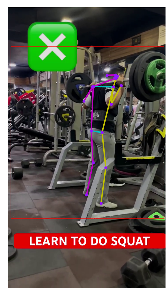

KeyboardInterrupt: 

In [37]:
import time

def to_mp4(output_images, filename, fps=30):
    clip = ImageSequenceClip([image[..., ::-1] for image in output_images], fps=fps)
    clip.write_videofile(filename, codec='libx264')

video_path = video_file



print("OpenCV-Python Version {}".format(cv2.__version__))

cap = cv2.VideoCapture(video_path)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
image_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
image_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

crop_region = init_crop_region(image_height, image_width)
# cv2.namedWindow('Video with Subtitles', cv2.WINDOW_NORMAL)
# cv2.resizeWindow('Video with Subtitles', 800, 600)
length = int(cap. get(cv2. CAP_PROP_FRAME_COUNT))
print( length )
output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
last_frame = 0
frame_idx = 0
dq = collections.deque()
curr_sub_start = 0

joint_cordinates_ts = np.array([])

angles_ts = np.array([])
try:
    while cap.isOpened():
        #cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        print("frame.shape")
        print(frame.shape)
        current_time = frame_idx / fps
        keypoints_with_scores = run_inference(
                movenet, frame, crop_region,
                crop_size=[input_size, input_size])

        img, angles_with_avg_score, joint_cordinates, rectangle = draw_prediction_on_image(
                frame.astype(np.int32),
                keypoints_with_scores, crop_region=crop_region,
                close_figure=True, output_image_height=300)

        print(type(joint_cordinates))
        print(type(angles_with_avg_score))
        print((joint_cordinates))
        print((angles_with_avg_score))
        # print(joint_cordinates)
        data = np.concatenate((joint_cordinates, angles_with_avg_score))

        clear_output(wait=True)
        print(frame_idx)


        # while(subtitles[curr_sub_start]['start']<current_time):
        #   #print(subtitles[curr_sub_start]['text'])
        #   dq.append(curr_sub_start)
        #   curr_sub_start=curr_sub_start+1
        # if(len(dq) >0):
        #   while(subtitles[dq[0]]['start'] + subtitles[dq[0]]['duration']<current_time):
        #     dq.popleft()
        # print(angles_with_avg_score[-1] )
        # print(get_last_frame(filename))

        if (frame_idx>get_last_frame(filename)):
          print("dodawanie")
          # description = ''
          # for x in dq:
          #   description+=subtitles[x]['text']
          add_row(filename,frame_idx,data)

        if (angles_ts.shape[0]==0):
            angles_ts = angles_with_avg_score[:-1]
        else:
            angles_ts = np.vstack((angles_ts, angles_with_avg_score[:-1]))

        #if (angles_with_avg_score[-1] > 0.5):
        if (joint_cordinates_ts.shape[0]==0):
            joint_cordinates_ts = joint_cordinates
        else:
            joint_cordinates_ts = np.vstack((joint_cordinates_ts,joint_cordinates))

        #print(joint_cordinates_ts)

        # if rectangle is not None:
        #   #print(rectangle)
        #   #print(img.shape)
        #   img = print_image_segments(img, rectangle)

        cv2_imshow(img)
        #time.sleep(0.50)
        crop_region = determine_crop_region(
                keypoints_with_scores, image_height, image_width)
        plt.plot(angles_ts)
        plt.show()
        # print("Crop region:")
        # print(crop_region)
        # rect = get_rect_from_crop(img,crop_region)
        # print(rect)
        # if(rect[0]>0 and rect[1]>0):
        #   print_image_segments(img,rect)
        # time.sleep(0.10)
        #bar.update(progress(frame_idx, num_frames-1))
        #last_frame = frame_idx
        #key = cv2.waitKey(100)  # Adjust the delay as needed (milliseconds)
        #input("Press Enter to continue...")
        # if key == 27:  # ESC key to exit
        #   break
        # elif key == 83 or key == 100:
        frame_idx += 1
finally:
    cap.release()
    cv2.destroyAllWindows()
# Prepare MP4 visualization.
#to_mp4(output_images, 'output.mp4', fps=fps)

## Load csv file with time series

In [ ]:
def load_to_ndarray(filename):
    # Wczytanie danych numerycznych (pomijając tekstową kolumnę na końcu)
    data = np.genfromtxt(filename, delimiter=',')
    return data

time_series = load_to_ndarray("data.csv")


[[  0.         234.         443.         ... 179.         177.
    0.60063356]
 [  1.         235.         443.         ... 179.         177.
    0.79231972]
 [  2.         232.         444.         ... 178.         178.
    0.83363736]
 ...
 [352.         226.         441.         ... 178.         177.
    0.80187923]
 [353.         229.         441.         ... 178.         177.
    0.80480796]
 [354.         228.         441.         ... 178.         177.
    0.81861168]]


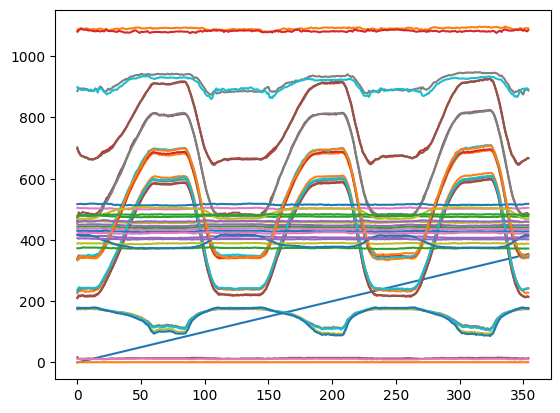

In [ ]:
print(time_series)
plt.plot(time_series)
plt.show()

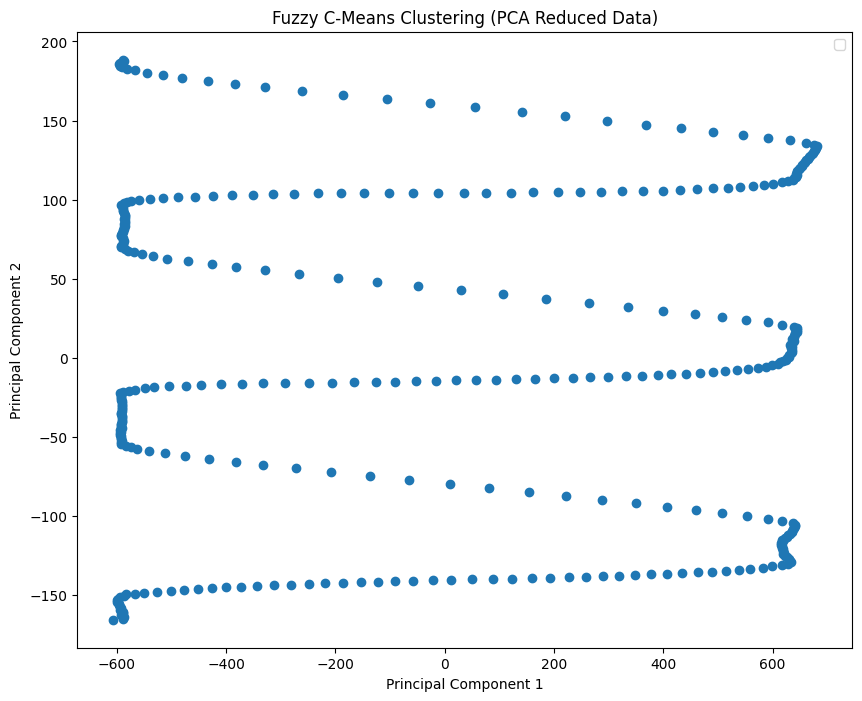

In [ ]:
from sklearn.decomposition import PCA

def plot_pca(data):
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data)

        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        plt.scatter(data_pca[:, 0], data_pca[:, 1])

        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering (PCA Reduced Data)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()
plot_pca(time_series)

## Segemnt data

In [ ]:
import stumpy
import matplotlib.pyplot as plt
from stumpy.floss import _cac
from scipy.signal import argrelextrema


def get_indices_matricies(data,m):
    mp = stumpy.stump(data, m)
    return mp[:, 1]

def get_cac_curves(mpi,L,exclusion_factor):
    cac = _cac(mpi, L=L, excl_factor=exclusion_factor)
    return cac

class Fluss:
    def __init__(self,L,exclusion_factor):
        self.L=L
        self.exclusion_factor = exclusion_factor
        self.custom_extraction_zone = 3*L
        self.last_regimes = None
        self.last_cac = None
        self.last_data = None

    def set_custom_regime_extraction(self, extraction_zone ):
        self.custom_extraction_zone = extraction_zone

    def predict_regimes(self,data):
        self.last_data = data
        mp = stumpy.stump(data, m=self.L)
        cac = _cac(mp[:, 1], L=self.L, excl_factor=self.exclusion_factor)
        self.last_cac = cac

        local_minima_indices = argrelextrema(cac, np.less, order=self.custom_extraction_zone)[0]
        self.last_regimes = local_minima_indices
        return cac, local_minima_indices


    def m_predict_regimes(self,data):
        self.last_data = data
        m_mp = np.apply_along_axis(get_indices_matricies, 0, data,self.L)
        m_cac = np.apply_along_axis(get_cac_curves, 0, m_mp,self.L,self.exclusion_factor)
        mean_cac = np.mean(m_cac, axis=1)

        self.last_cac = mean_cac

        local_minima_indices = argrelextrema(mean_cac, np.less, order=self.custom_extraction_zone)[0]
        self.last_regimes = local_minima_indices
        return mean_cac, local_minima_indices


    def print_latest_output(self, original_points = None):
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
        axs[0].plot(range(self.last_data.shape[0]), self.last_data)
        axs[1].plot(range(self.last_cac.shape[0]), self.last_cac, color='C1')

        for i in self.last_regimes:
            axs[0].axvline(x=i, linestyle="dashed")
            axs[1].axvline(x=i, linestyle="dashed")

        if original_points is not None:
            for i in original_points:
                axs[0].axvline(x=i, linestyle="dashed", color='g')
                axs[1].axvline(x=i, linestyle="dashed", color='g')

        plt.show()


#eval


# FlussRegimeSegmentator = Fluss(1000,3,5)
# FlussRegimeSegmentator.turn_custom_regime_extraction()
# # cac , regimes = FlussRegimeSegmentator.predict_regimes(data)
# # FlussRegimeSegmentator.print_latest_output()

# m_data = cricet_stacked_ndarray.astype(np.float64)
# cac , m_cac ,regimes = FlussRegimeSegmentator.m_predict_regimes(m_data)
# FlussRegimeSegmentator.print_latest_output()

In [ ]:
FlussRegimeSegmentator = Fluss(90,1)
#FlussRegimeSegmentator.turn_custom_regime_extraction()
cac, regimes = FlussRegimeSegmentator.m_predict_regimes(time_series)


[90]
[  0  90 355]


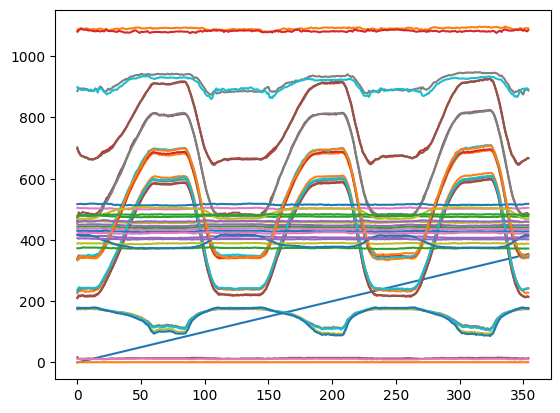

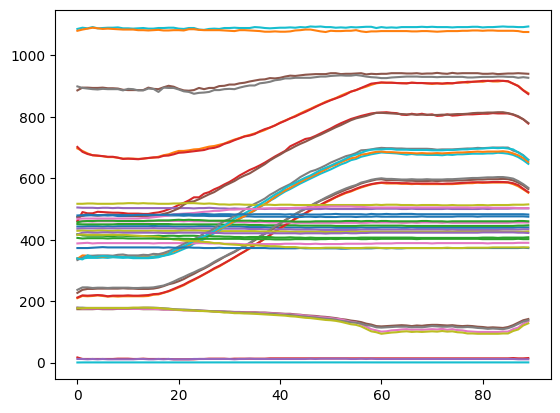

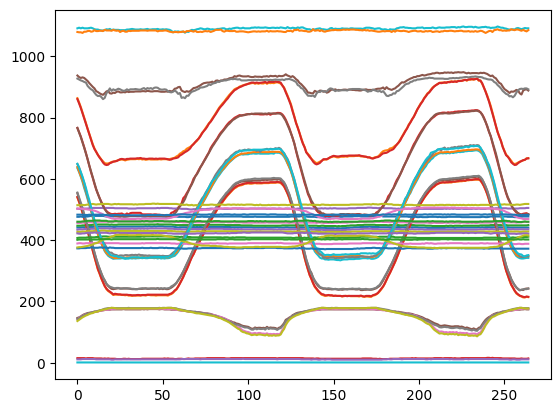

In [ ]:
def cut_series_multidimensional(data, cut_indices):
    # Dodaj indeks początku (0) oraz końca tablicy (len(data))
    print(cut_indices)
    cut_indices = np.concatenate(([0], cut_indices, [len(data)]))  # Użyj np.concatenate

    print(cut_indices)
    # Tworzymy listę wycinków dla każdego segmentu
    segments = [data[cut_indices[i]:cut_indices[i+1],:] for i in range(len(cut_indices)-1)]

    return segments


# Wywołanie funkcji
segments = cut_series_multidimensional(time_series[:,2:], regimes)
#print(time_series)
#print(regimes[3])
#print(segments)
plt.plot(time_series)
plt.show()
for seg in segments:
   plt.plot(seg)
   plt.show()


## Anomaly detection

(355, 42)
306
[248 249 250 131 132 133 133 134 135 136 136 137 138 139 140 141 142 142
 143 144 145 264 264 265 266 267 268 269 270 271 272 273 158 159 160 161
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 177
 178 179 180 181 182 299 300 301 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 218 219 220 220 221 222 223 224 226 227 228 229
 229 230 231 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 255 256 257 258 259 260 261 262
  19  20  21  22 266 267 268 268 269 270 271 271 272 273 274 275 276 277
 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294 294 295
 296 297 298 299 300 301 302 303 304 305  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 101 102 103 103 104 105 106 108 110 111 112 113
 114 115 116 117 118 119 120 121 122 

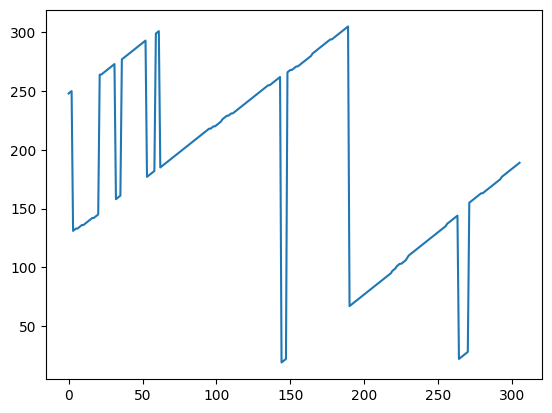

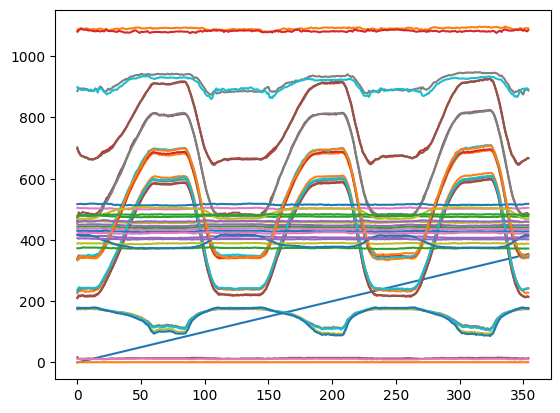

In [ ]:
print(time_series.shape)
(P, I) = stumpy.mstump(time_series.T,50)
print(len(I[5,:]))
print(I[5,:])
plt.plot(I[5,:])
plt.show()

plt.plot(time_series)
plt.show()

[[118 235]]
[118 235]
[  0 118 235 355]


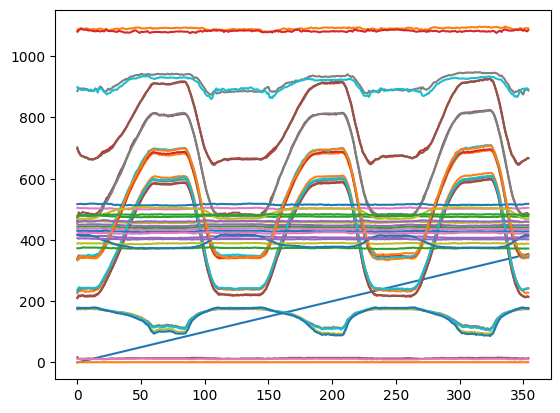

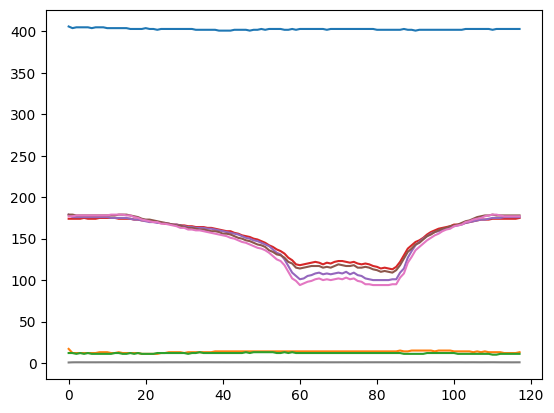

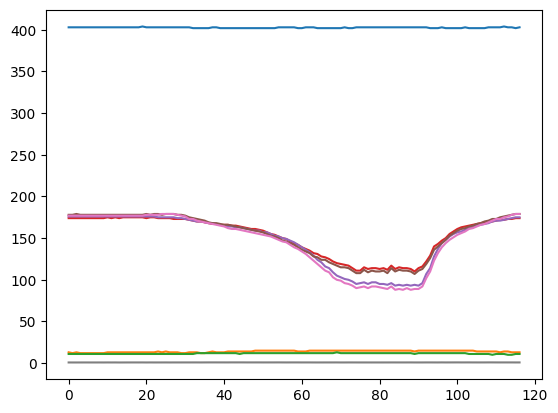

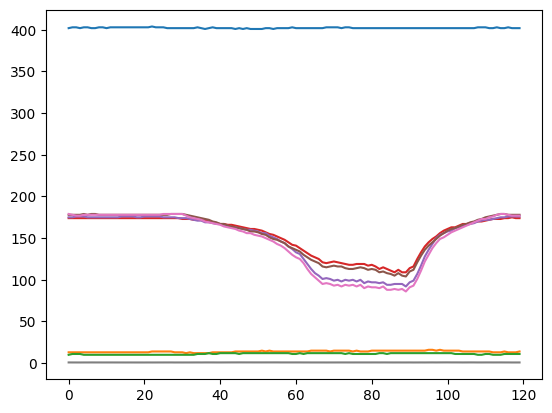

In [ ]:
# matches = stumpy.match(time_series[150:250,:], time_series)
# print(matches)


mps, indices = stumpy.mstump(time_series.T, m=120)
output = stumpy.mmotifs(time_series.T,
    mps,
    indices)
print(output[1])
segments = cut_series_multidimensional(time_series, output[1][0])
# #print(time_series)
# #print(regimes[3])
# #print(segments)
plt.plot(time_series)
plt.show()
for seg in segments:
    plt.plot(seg[:,34:])
    plt.show()

(118, 42)


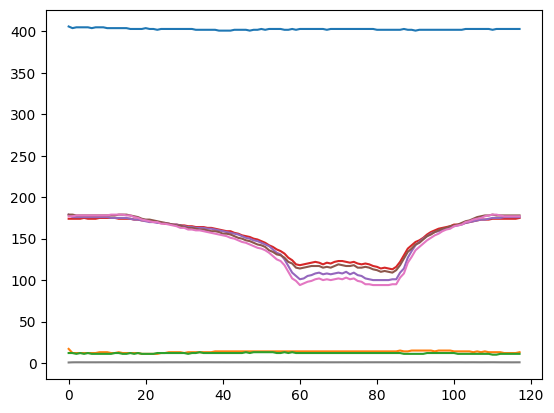

(117, 42)


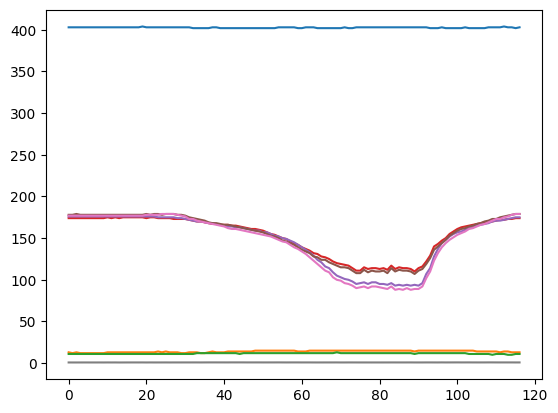

(120, 42)


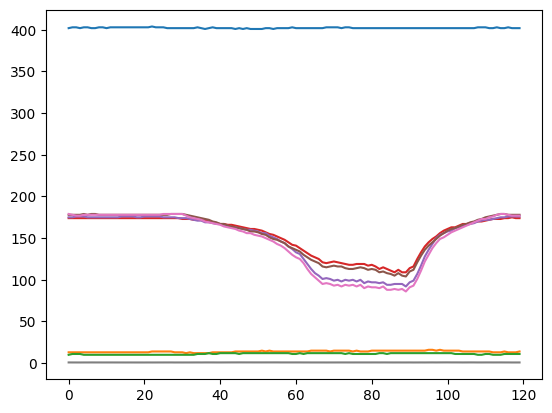

In [ ]:
for seg in segments:
  print(seg.shape)
  plt.plot(seg[:,34:])
  plt.show()
    # plt.plot(seg)
    # plt.show()

## Fail Video

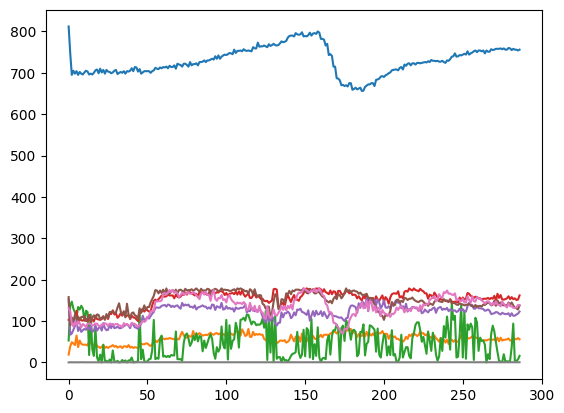

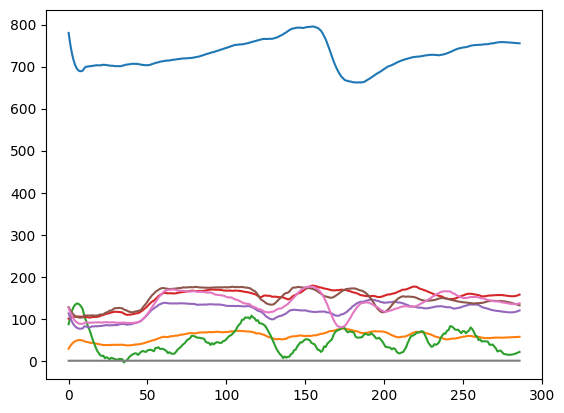

In [44]:
from scipy.signal import medfilt, savgol_filter


short_time_series = load_to_ndarray(filename)
# Rysowanie serii od kolumny 34 włącznie do końca
for i in range(34, short_time_series.shape[1]):
    plt.plot(short_time_series[:, i], label=f'Column {i}')  # Dodanie etykiety
plt.show()

for i in range(34, short_time_series.shape[1]):
    plt.plot(savgol_filter(short_time_series[:, i], window_length = 20, polyorder = 3), label=f'Column {i}')  # Dodanie etykiety
plt.show()


# Wyświetlenie wykresu
plt.show()

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.         ...   0.32030123   0.
    0.        ]
 [  0.           1.         206.         ...  37.           0.32030123
    0.        ]
 ...
 [  0.         166.         191.         ...  64.           0.51092792
    0.        ]
 [  0.           0.         167.         ...   0.51092792   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


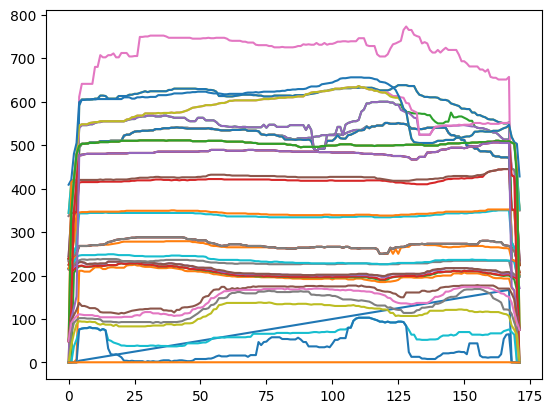

In [ ]:
from scipy.signal import medfilt

# Filtr medianowy z oknem 3
filtered_data = medfilt(short_time_series, kernel_size=9)

print(filtered_data)
plt.plot(filtered_data)
plt.show()

### This is optional tool to run main loop faster without processing text

In [ ]:
cap = cv2.VideoCapture(video_file)
dq = collections.deque()
cv2.namedWindow('Video with Subtitles', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video with Subtitles', 800, 600)
last_frame = 0
current_frame = 0
fps = cap.get(cv2.CAP_PROP_FPS)
curr_sub_start = 0
import os
clear = lambda: os.system('cls')

try:
    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        current_time = current_frame / fps

        ret, frame = cap.read()

        if not ret:
            break
        if last_frame != current_frame:
            while subtitles[curr_sub_start]['start'] < current_time:
                print(subtitles[curr_sub_start]['text'])
                dq.append(curr_sub_start)
                curr_sub_start += 1
            if len(dq) > 0:
                while subtitles[dq[0]]['start'] + subtitles[dq[0]]['duration'] < current_time:
                    dq.popleft()

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray_frame, threshold1=100, threshold2=200)

            sub_index = 0
            for x in dq:
                cv2.putText(frame, subtitles[x]['text'], (50, 50 + 50 * sub_index), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
                sub_index += 1

            #img = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            detection_result = detector.process(frame)
            if(detection_result.pose_landmarks):
                clear()
                print("lewe ramie: ")
                print(detection_result.pose_world_landmarks.landmark[11])
                print("prawe ramie: ")
                print(detection_result.pose_world_landmarks.landmark[12])
                print("lewe biodro: ")
                print(detection_result.pose_world_landmarks.landmark[23])
                print("prawe biodro: ")
                print(detection_result.pose_world_landmarks.landmark[24])
                #print(detection_result.pose_landmarks[11])
                body_angle = calculate_body_rotation_angle(detection_result.pose_landmarks.landmark)
                body_angle_3d = calculate_body_rotation_angle(detection_result.pose_world_landmarks.landmark)
                print("kat na zdjeciu: ")
                print(body_angle)
                print("kat w 3d: ")
                print(body_angle_3d)

                # wheter human is front or back to camera
                front = False if detection_result.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x > 0 else True
                left = True if detection_result.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].z < detection_result.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].z else False
                print("przod:")
                print(front)
                print("lewo:")
                print(front)
                #cv2.putText(frame, body_angle, (50, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
                annotated_image = draw_landmarks_on_image(frame, detection_result)
                bgr_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
                cv2.imshow('Video with Subtitles', bgr_image)
            else:
               cv2.imshow('Video with Subtitles', frame)

        #cv2.imshow('Video with Subtitles', frame)

        #cv2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))    # Wait for user input (right arrow key to go to the next frame)
        key = cv2.waitKey(30)  # Adjust the delay as needed (milliseconds)
        last_frame = current_frame
        if key == 27:  # ESC key to exit
            break
        elif key == 83 or key == 100:
            current_frame += 1
finally:
    cap.release()
    cv2.destroyAllWindows()

we will approach the squat in two phases
lewe ramie: 
x: -0.10126257
y: -0.38646343
z: 0.25926033
visibility: 0.9979285

prawe ramie: 
x: 0.16045028
y: -0.42304328
z: 0.1250287
visibility: 0.9999043

lewe biodro: 
x: -0.054906376
y: 0.015925106
z: 0.062126763
visibility: 0.99943036

prawe biodro: 
x: 0.05485576
y: -0.015774563
z: -0.061007895
visibility: 0.99995184

kat na zdjeciu: 
-2.5454905818027704
kat w 3d: 
-7.956737334590427
przod:
False
lewo:
False
lewe ramie: 
x: -0.09328172
y: -0.40218708
z: 0.26579478
visibility: 0.9968651

prawe ramie: 
x: 0.1601431
y: -0.42502868
z: 0.12521593
visibility: 0.99986684

lewe biodro: 
x: -0.056926046
y: 0.015943814
z: 0.06404112
visibility: 0.99944574

prawe biodro: 
x: 0.056657165
y: -0.01579237
z: -0.0630135
visibility: 0.9999524

kat na zdjeciu: 
-7.048258708727123
kat w 3d: 
-5.150247842948468
przod:
False
lewo:
False
lewe ramie: 
x: -0.076876715
y: -0.41313618
z: 0.2614864
visibility: 0.9963455

prawe ramie: 
x: 0.16003326
y: -0.4452573
z

### divide text into sentences and add punctuation with ml model

In [ ]:

text =''
for obj in subtitles:
    text+=obj['text']

print(len(text))
print(text)


from deepmultilingualpunctuation import PunctuationModel
model = PunctuationModel()

result = model.restore_punctuation(text)
print(len(result))



4705
we will approach the squat in two phasesfirst unloaded to solve problemsassociated with the bottom position andthen loaded to learn how to apply thebottom position to the hip drive usedfor heavier weights since the majorityof the problems with the squat happenedat the bottom this method expedites theprocess quite effectively we will use afairly neutral foot placement with theheels about shoulder width apart and thetoes pointed out at about 30 degreesmany people will assume a stance withtoes pointed too forward so you may needto point them out more than you want tonext you're going to assume the positionyou will be in at the bottom of a squatwithout the barsquat down all the way to a position inwhich the apex of the hip crease dropsjust below the top of the patella putyour elbows against your knees with thepalms of your hands together and shoveyour knees out notice your feet are flaton the floor your knees are shoved outto where they are in a parallel linewith your feet and just a 

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.NONE"` instead.
  warnings.warn(


4790


### removing artificial connections in words (auto generating subtitles from yt isn't ideal)
### also pos-tags are added here

In [ ]:
sents = nltk.sent_tokenize(result)

import wordsegment
from wordsegment import load, segment
load()
from nltk.tokenize import word_tokenize

# segment powoduje również tokenizacje zdania dlatego ten etap(tokenizacji) zostanie pominięty.
sents = [(segment(sent)) for sent in sents]
#porter = nltk.PorterStemmer()
#sents = [[porter.stem(t) for t in sent] for sent in sents]
sents = [nltk.pos_tag(sent) for sent in sents]
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}
      {<NNP>+}
"""
# grammar = r"""
#   NP: {<DT>?<JJ>*<NN>}
#   VP: {<VB.*><NP|PP>*}
#   PP: {<IN><NP>}
#   ADJP: {<JJ>}
#   ADVP: {<RB.*>}
# """
cp = nltk.RegexpParser(grammar)

# class ConsecutiveNPChunkTagger(nltk.TaggerI):

#     def __init__(self, train_sents):
#         train_set = []
#         for tagged_sent in train_sents:
#             untagged_sent = nltk.tag.untag(tagged_sent)
#             history = []
#             for i, (word, tag) in enumerate(tagged_sent):
#                 featureset = npchunk_features(untagged_sent, i, history)
#                 train_set.append( (featureset, tag) )
#                 history.append(tag)
#         self.classifier = nltk.MaxentClassifier.train(
#             train_set, algorithm='megam', trace=0)

#     def tag(self, sentence):
#         history = []
#         for i, word in enumerate(sentence):
#             featureset = npchunk_features(sentence, i, history)
#             tag = self.classifier.classify(featureset)
#             history.append(tag)
#         return zip(sentence, history)

# class ConsecutiveNPChunker(nltk.ChunkParserI):
#     def __init__(self, train_sents):
#         tagged_sents = [[((w,t),c) for (w,t,c) in
#                          nltk.chunk.tree2conlltags(sent)]
#                         for sent in train_sents]
#         self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

#     def parse(self, sentence):
#         tagged_sents = self.tagger.tag(sentence)
#         conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
#         return nltk.chunk.conlltags2tree(conlltags)

# def npchunk_features(sentence, i, history):
#      word, pos = sentence[i]
#      return {"pos": pos}
# chunker = ConsecutiveNPChunker(train_sents)
# print(chunker.evaluate(test_sents))


# sents = [cp.parse(sent) for sent in sents]





In [ ]:
# nltk.download('maxent_ne_chunker')
# nltk.download('treebank')
# print(sents[30])
sent = nltk.corpus.treebank.tagged_sents()[22]
#print(sent)
print(sents[15])
#print(nltk.ne_chunk(sent))
print(nltk.ne_chunk(sents[25]))

# sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
# ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

# grammar = "NP: {<DT>?<JJ>*<NN>}"

# cp = nltk.RegexpParser(grammar)
# result = cp.parse(sentence)
# print(result)
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
# print(cp.evaluate(sents))
# result.draw()

[('measured', 'VBN'), ('from', 'IN'), ('the', 'DT'), ('markings', 'NNS'), ('placed', 'VBN'), ('on', 'IN'), ('the', 'DT'), ('bar', 'NN'), ('for', 'IN'), ('this', 'DT'), ('purpose', 'NN'), ('a', 'DT'), ('standard', 'JJ'), ('powerbar', 'NN'), ('has', 'VBZ'), ('16to17', 'CD'), ('inches', 'NNS'), ('between', 'IN'), ('the', 'DT'), ('ends', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('inside', 'JJ'), ('neural', 'JJ'), ('and', 'CC'), ('32', 'CD'), ('inches', 'NNS'), ('between', 'IN'), ('the', 'DT'), ('finger', 'NN'), ('marks', 'NNS')]
(S
  again/RB
  heels/NNS
  should/MD
  be/VB
  about/IN
  shoulder/NN
  width/NNS
  apart/RB
  with/IN
  toes/NNS
  pointed/VBN
  out/RP
  about/IN
  30/CD
  degrees/NNS
  at/IN
  this/DT
  point/NN
  you/PRP
  are/VBP
  ready/JJ
  to/TO
  squat/VB
  with/IN
  the/DT
  empty/JJ
  bar/NN)


### Finding sentences with technique rules(unfinished) (regexp: noun(body part) and verb)

In [ ]:
text = "When performing squats with a barbell, ensure your back is straight, knees do not extend beyond your toes, and the barbell rests securely on your shoulders."

from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
part = wn.synsets('body_part')[0]

def is_body_part(candidate):
    for ss in wn.synsets(candidate):
        # only get those where the synset matches exactly
        name = ss.name().split(".", 1)[0]
        if name != candidate:
            continue
        hit = part.lowest_common_hypernyms(ss)
        if hit and hit[0] == part:
            return True
    return False

# for word in sents[0]:
#     print(is_body_part(word[0]), word[0], sep="\t")

# Procesowanie każdego zdania
# for sentence in sents:
#     if any(is_body_part(t[0].lower()) for t in sentence):
#         print(f"Zdanie zawiera część ciała: {sentence}")

import nltk
from nltk import CFG
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.parse import ChartParser

# Lista części ciała
body_parts = ["head", "arm", "leg", "hand", "foot", "eye", "ear", "nose", "mouth", "shoulder", "knee", "elbow"]

# Definicja gramatyki bezkontekstowej z użyciem POS tags
grammar = CFG.fromstring("""
  S -> NP VP
  NP -> DT JJNN | JJNN
  VP -> VBZ NP | VBZ ADJP | VBZ PP
  DT -> 'the' | 'a' | 'his' | 'her'
  JJNN -> JJ NN | JJNN JJ NN
  JJ -> 'badly' | 'quickly' | 'slowly' | 'fast'
  NN -> 'head' | 'arm' | 'leg' | 'hand' | 'foot' | 'eye' | 'ear' | 'nose' | 'mouth' | 'shoulder' | 'knee' | 'elbow'
  VBZ -> VB
  ADJP -> JJ NP
  NP -> DT JJNN
  PP -> IN NP
  IN -> 'in'
""")

# Tworzenie parsera
parser = ChartParser(grammar)

# Tokenizacja tekstu na zdania
for sentence in sents:
    # Sprawdzanie czy zdanie pasuje do gramatyki
    #print(sentence)
    words = [word for word, tag in sentence]
    try:
        for tree in parser.parse(words):
            # # Sprawdzanie czy pierwsza fraza rzeczownikowa jest częścią ciała
            # np = tree[0]
            # if np.label() == 'NP' and np[0][0].lower() in body_parts:
            #     print(f"Zdanie zawiera część ciała jako podmiot: {sentence}")
            tree.pretty_print()
    except ValueError:
            # Jeżeli parser nie znajdzie pasującego drzewa, przechodzi do następnego zdania
        #print("nie ma drzewa")
        continue
import re

#pattern = r'(head|arm|leg|hand|foot|eye|ear|nose|back|mouth|shoulder|knee|elbow)'
pattern = r'\b(head|arm|leg|hand|foot|eye|ear|nose|back|mouth|shoulder|knee|elbow)\b\s+(\w+)'

sents_for_regexp = nltk.sent_tokenize(result)
sents_for_regexp = [(segment(sent)) for sent in sents_for_regexp]
for sentence in sents_for_regexp:
    #print(sentence)
    sem = ' '.join([str(elem) for elem in sentence])
    #print(sem)
    match = re.search(pattern,sem)
    if match:
        print(sem)
        #print(match.string)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


we will use a fairly neutral foot placement with the heels about shoulder width apart and the toes pointed out at about 30 degrees many people will assume a stance with toes pointed too forward so you may need to point them out more than you want
your back should be as flat as you can get it
also notice that your back is inclined at about a45 degree angle not at all vertical and your eyes are looking down at the floor a few feet in front of you
this movement keeps your weight solidly over the whole foot instead of letting it shift to the toes
grip width for the squat will vary with shoulder width and flexibility but in general the hands will be between these two markings
the elbows should be lifted up to trap the bar between the hands and the back elbows should be up but not high
with your grip in place and your hands and thumbs on top of the bar dip your head under the bar and come up into position with the bar on your back just below the spine of the scapula the bone you feel at the 

In [ ]:
for sent in sents:
    for tuple in sent:
        print(tuple[0],end = " ")
    print("\n")

we will approach the squat in two phases first unloaded to solve problems associated with the bottom position and then loaded to learn how to apply the bottom position to the hip drive used for heavier weights 

since the majority of the problems with the squat happened at the bottom this method expedites the process quite effectively 

we will use a fairly neutral foot placement with the heels about shoulder width apart and the toes pointed out at about 30 degrees many people will assume a stance with toes pointed too forward so you may need to point them out more than you want 

to next your e going to assume the position you will be in at the bottom of a squat without the bar squat down all the way to a position in which the apex of the hip crease drops just below the top of the patella 

put your elbows against your knees with the palms of your hands together and shove your knees out 

notice your feet are flat on the floor 

your knees are shoved out to where they are in a paralle

### main loop of the program

In [ ]:
cap = cv2.VideoCapture(video_file)
dq = collections.deque()
cv2.namedWindow('Video with Subtitles', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video with Subtitles', 800, 600)

current_frame = 0
fps = cap.get(cv2.CAP_PROP_FPS)
curr_sub_start = 0
while True:
    cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    current_time = current_frame / fps

    ret, frame = cap.read()

    if not ret:
        break


    while(subtitles[curr_sub_start]['start']<current_time):
        print(subtitles[curr_sub_start]['text'])
        dq.append(curr_sub_start)
        curr_sub_start=curr_sub_start+1
    if(len(dq) >0):
        while(subtitles[dq[0]]['start'] + subtitles[dq[0]]['duration']<current_time):
            dq.popleft()


    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_frame, threshold1=100, threshold2=200)

    sub_index=0
    for x in dq:
        cv2.putText(frame, subtitles[x]['text'], (50, 50+50*sub_index), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
        sub_index+=1


    img = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

    detection_result = detector.detect(img)
    # body_angle = calculate_body_rotation_angle(detection_result.pose_landmarks.landmark)
    # cv2.putText(frame, body_angle, (50, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)


    annotated_image = draw_landmarks_on_image(img.numpy_view(), detection_result)
    bgr_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

    # Display the image using OpenCV
    #cv2.imshow('Video with Subtitles', frame)
    cv2.imshow('Video with Subtitles', bgr_image)
    #cv2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))    # Wait for user input (right arrow key to go to the next frame)
    key = cv2.waitKey(30)  # Adjust the delay as needed (milliseconds)
    if key == 27:  # ESC key to exit
        break
    elif key == 83 or key == 100:
        current_frame += 1
cap.release()
cv2.destroyAllWindows()


AttributeError: 'list' object has no attribute 'landmark'